In [1]:
import os
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import csv
import string
import pandas as pd

In [2]:
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [3]:
database = 'pitzer'
PHdir = '/Users/siavash/Software/phreeqc-3.4.0-12927/bin/Phreeqc'
OUTdir = '/Users/siavash/Rice/Oman/BrineSalinity/PHREEQC/PythonEX/OUTputs'
INdir = '/Users/siavash/Rice/Oman/BrineSalinity/PHREEQC/PythonEX/INputs'
database_path = '/Users/siavash/Software/phreeqc-3.4.0-12927/database'

mm = ['o', 's', 'x', '*', 'v', '<', '>', 'h', 'H']

In [4]:
NaCl  = 1             # Added salt

added_salt = 'SrCl2'  # Added salt
cat = 'Sr'            # Cation of the added salt
ani = 'Cl'            # Anion of the added salt
cat_phqc = 'Sr'       # Phreeqc form of the cation
ani_phqc = 'Cl'       # Phreeqc form of the anion
cat_ch = 2            # Charge of the anion
ani_ch = 1
cat_mo = 1
ani_mo = 2

T = 20
P = 493.462
X1 = 2
X2 = 5.5
st = 0.5
X = np.arange(X1, X2, st)


if cat_ch != 1:
    cation = ("%s+%s" % (cat, cat_ch))                                         # Charged cation of the added salt
else:
    cation = ("%s+" % cat)

if ani_ch != 1:
    anion = ('%s-%s' % (ani, ani_ch))                                         # Charged cation of the added salt
else:
    anion = ('%s-' % ani)

In [5]:
def phreeqc_sim(phqc_path, phqc_input):

   cmd_string = ("%s %s" % (phqc_path, phqc_input))
   os.system(cmd_string)

In [6]:
def nacl_run(phdir, outdir, indir, db_path, db_name, t, p, nacl):

    output_file = ("%s/%sM%s.txt" % (outdir, nacl, 'NaCl'))
    input_file = ("%s/%sM%s.phr" % (indir, nacl, 'NaCl'))

    #########################################################
    input_string = ('''
        DATABASE %s/%s.dat
        TITLE  Example Temperature dependance of solubility of halite
        SOLUTION 1 brine
        units    mol/kgw
        temp     %s
        pressure %s
        pH                7   charge
        Na   %s
        Cl   %s
        -water 1 # kg
        REACTION_TEMPERATURE  1
            20.0 110.0 in 91 steps
        SELECTED_OUTPUT
        -file %s
        -temperature
        -si Halite
        -activities Na+ Cl-
        -ionic_strength
        -molalities Na+ Cl-
        -state false
        END''' % (db_path, db_name, t, p, nacl, nacl, output_file))

    input_write = open(input_file, "w")
    input_write.write(input_string)
    input_write.close()

    phreeqc_sim(phdir, input_file)

    header = ['sim', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp', 'mu', 'm_cat', 'm_ani', 'la_cat', 'la_ani',
              'si_H']
    sim_result = pd.read_table(output_file, delim_whitespace=True, header=None, names=header)
    ph = pd.to_numeric(sim_result['pH'][1:])
    temp = pd.to_numeric(sim_result['temp'][1:])
    I = pd.to_numeric(sim_result['mu'][1:])
    m_cat = pd.to_numeric(sim_result['m_cat'][1:])
    m_ani = pd.to_numeric(sim_result['m_ani'][1:])
    a_cat = pd.to_numeric(sim_result['la_cat'][1:])
    a_ani = pd.to_numeric(sim_result['la_ani'][1:])
    si_h = pd.to_numeric(sim_result['si_H'][1:])

    log_gam_na = a_cat - np.log10(m_cat)
    log_gam_cl = a_ani - np.log10(m_ani)
    gam_na = np.power(10, log_gam_na)
    gam_cl = np.power(10, log_gam_cl)  # 10.^(log_gam_ani);
    mean_gam_nacl = np.power(np.power(gam_na, 1) * np.power(gam_cl, 1), (np.divide(1.0, 2.0)))  # (gam_cat.^cat_mo.*gam_ani.^ani_mo).^(1/(ani_mo+cat_mo));
    log_mean_gam_nacl = np.log10(mean_gam_nacl)

    return si_h, log_gam_na, log_gam_cl, mean_gam_nacl, log_mean_gam_nacl
########################################################################################################################

In [7]:
# added salt does not contain Na and Cl ions
def mixsalt_run1(phdir, outdir, indir, db_path, db_name, t, p, x, catmo, animo, nacl,ctph, anph, salt, salt_cation, salt_anion):
    ph = np.zeros((92, len(x)))
    temp = np.zeros((92, len(x)))
    i_strength = np.zeros((92, len(x)))
    m_cat = np.zeros((92, len(x)))
    m_ani = np.zeros((92, len(x)))
    m_na = np.zeros((92, len(x)))
    m_cl = np.zeros((92, len(x)))
    a_cat = np.zeros((92, len(x)))
    a_ani = np.zeros((92, len(x)))
    a_na = np.zeros((92, len(x)))
    a_cl = np.zeros((92, len(x)))
    si_h = np.zeros((92, len(x)))

    c = 0
    for m in x:
        xc = catmo * m
        xa = animo * m
        output_file = ("%s/%sM%s_%sMNaCl.txt" % (outdir, m, salt, nacl))
        input_file = ("%s/%sM%s_%sMNaCl.phr" % (indir, m, salt, nacl))

        #########################################################
        input_string = ('''
        DATABASE %s/%s.dat
        TITLE  Example Temperature dependance of solubility of halite
        SOLUTION 1 brine
        units    mol/kgw
        temp     %s
        pressure %s
        pH                7   charge
        Na   %s
        Cl   %s
        %s   %s
        %s   %s
        -water 1 # kg
        REACTION_TEMPERATURE  1
            20.0 110.0 in 91 steps
        SELECTED_OUTPUT
        -file %s
        -temperature
        -si Halite
        -activities Na+ Cl- %s %s
        -ionic_strength 
        -molalities Na+ Cl- %s %s
        -state false
        END''' % (db_path, db_name, t, p, nacl, nacl, ctph, xc, anph, xa, output_file, salt_cation, salt_anion, salt_cation, salt_anion))

        input_write = open(input_file, "w")
        input_write.write(input_string)
        input_write.close()
        #########################################################

        phreeqc_sim(phdir, input_file)
        header = ['sim', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp', 'mu',
                  'm_na', 'm_cl', 'm_cat', 'm_ani', 'la_na', 'la_cl', 'la_cat',
                  'la_ani', 'si_H']

        sim_result = pd.read_table(output_file, delim_whitespace=True, header=None, names=header)
        ph[:, c] = pd.to_numeric(sim_result['pH'][1:])
        temp[:, c] = pd.to_numeric(sim_result['temp'][1:])
        i_strength[:, c] = pd.to_numeric(sim_result['mu'][1:])
        m_cat[:, c] = pd.to_numeric(sim_result['m_cat'][1:])
        m_ani[:, c] = pd.to_numeric(sim_result['m_ani'][1:])
        m_na[:, c] = pd.to_numeric(sim_result['m_na'][1:])
        m_cl[:, c] = pd.to_numeric(sim_result['m_cl'][1:])
        a_cat[:, c] = pd.to_numeric(sim_result['la_cat'][1:])
        a_ani[:, c] = pd.to_numeric(sim_result['la_ani'][1:])
        a_na[:, c] = pd.to_numeric(sim_result['la_na'][1:])
        a_cl[:, c] = pd.to_numeric(sim_result['la_cl'][1:])
        si_h[:, c] = pd.to_numeric(sim_result['si_H'][1:])

        c = c + 1
    #
    log_gam_cat = a_cat - np.log10(m_cat)
    log_gam_ani = a_ani - np.log10(m_ani)
    log_gam_na = a_na - np.log10(m_na)
    log_gam_cl = a_cl - np.log10(m_cl)

    gam_cat = np.power(10, log_gam_cat)
    gam_ani = np.power(10, log_gam_ani)
    gam_na = np.power(10, log_gam_na)
    gam_cl = np.power(10, log_gam_cl)

    mean_gam_salt = np.power(np.power(gam_cat, catmo) * np.power(gam_ani, animo), (
        np.divide(1.0, animo + catmo)))
    mean_gam_nacl = np.power(np.power(gam_na, 1) * np.power(gam_cl, 1),
                             (np.divide(1.0, 2.0)))

    log_mean_gam_nacl = np.log10(mean_gam_nacl)
    log_mean_gam_salt = np.log10(mean_gam_salt)
    return temp, si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_cat, log_gam_ani, log_gam_na, log_gam_cl
########################################################################################################################

In [8]:
# added salt does contain Cl ion but no Na
def mixsalt_run2(phdir, outdir, indir, db_path, db_name, t, p, x, catmo, animo, nacl, salt, ctph, salt_cation):
    ph = np.zeros((92, len(x)))
    temp = np.zeros((92, len(x)))
    i_strength = np.zeros((92, len(x)))
    m_cat = np.zeros((92, len(x)))
    m_na = np.zeros((92, len(x)))
    m_cl = np.zeros((92, len(x)))
    a_cat = np.zeros((92, len(x)))
    a_na = np.zeros((92, len(x)))
    a_cl = np.zeros((92, len(x)))
    si_h = np.zeros((92, len(x)))

    c = 0
    for m in x:
        xc = catmo * m
        xa = animo * m
        output_file = ("%s/%sM%s_%sMNaCl.txt" % (outdir, m, salt, nacl))
        input_file = ("%s/%sM%s_%sMNaCl.phr" % (indir, m, salt, nacl))

        cl = nacl + xa
        #########################################################
        input_string = ('''
        DATABASE %s/%s.dat
        TITLE  Example Temperature dependance of solubility of halite
        SOLUTION 1 brine
        units    mol/kgw
        temp     %s
        pressure %s
        pH                7   charge
        Na   %s
        Cl   %s
        %s   %s
        -water 1 # kg
        REACTION_TEMPERATURE  1
            20.0 110.0 in 91 steps
        SELECTED_OUTPUT
        -file %s
        -temperature
        -si Halite
        -activities Na+ Cl- %s 
        -ionic_strength
        -molalities Na+ Cl- %s
        -state false
        END''' % (db_path, db_name, t, p, nacl, cl, ctph, xc, output_file, salt_cation, salt_cation))

        input_write = open(input_file, "w")
        input_write.write(input_string)
        input_write.close()
        #########################################################

        phreeqc_sim(phdir, input_file)
        header = ['sim', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp', 'mu',
                  'm_na', 'm_cl', 'm_cat', 'la_na', 'la_cl', 'la_cat',
                  'si_H']

        sim_result = pd.read_table(output_file, delim_whitespace=True, header=None, names=header)
        ph[:, c] = pd.to_numeric(sim_result['pH'][1:])
        temp[:, c] = pd.to_numeric(sim_result['temp'][1:])
        i_strength[:, c] = pd.to_numeric(sim_result['mu'][1:])
        m_cat[:, c] = pd.to_numeric(sim_result['m_cat'][1:])
        m_na[:, c] = pd.to_numeric(sim_result['m_na'][1:])
        m_cl[:, c] = pd.to_numeric(sim_result['m_cl'][1:])
        a_cat[:, c] = pd.to_numeric(sim_result['la_cat'][1:])
        a_na[:, c] = pd.to_numeric(sim_result['la_na'][1:])
        a_cl[:, c] = pd.to_numeric(sim_result['la_cl'][1:])
        si_h[:, c] = pd.to_numeric(sim_result['si_H'][1:])

        c = c + 1

    log_gam_cat = a_cat - np.log10(m_cat)
    log_gam_na = a_na - np.log10(m_na)
    log_gam_cl = a_cl - np.log10(m_cl)

    gam_cat = np.power(10, log_gam_cat)
    gam_na = np.power(10, log_gam_na)
    gam_cl = np.power(10, log_gam_cl)

    mean_gam_salt = np.power(np.power(gam_cat, catmo) * np.power(gam_cl, animo), (
        np.divide(1.0, animo + catmo)))
    mean_gam_nacl = np.power(np.power(gam_na, 1) * np.power(gam_cl, 1),
                             (np.divide(1.0, 2.0)))

    log_mean_gam_nacl = np.log10(mean_gam_nacl)
    log_mean_gam_salt = np.log10(mean_gam_salt)
    return temp, si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_cat, log_gam_na, log_gam_cl
########################################################################################################################
########################################################################################################################


In [9]:
# added salt does contain Na ion but no Cl
def mixsalt_run3(phdir, outdir, indir, db_path, db_name, t, p, x, catmo, animo, nacl, salt, anph, salt_anion):
    ph = np.zeros((92, len(x)))
    temp = np.zeros((92, len(x)))
    i_strength = np.zeros((92, len(x)))
    m_ani = np.zeros((92, len(x)))
    m_na = np.zeros((92, len(x)))
    m_cl = np.zeros((92, len(x)))
    a_na = np.zeros((92, len(x)))
    a_cl = np.zeros((92, len(x)))
    a_ani = np.zeros((92, len(x)))
    si_h = np.zeros((92, len(x)))

    c = 0
    for m in x:
        xc = catmo * m
        xa = animo * m
        output_file = ("%s/%sM%s_%sMNaCl.txt" % (outdir, m, salt, nacl))
        input_file = ("%s/%sM%s_%sMNaCl.phr" % (indir, m, salt, nacl))

        na = nacl + xc
        #########################################################
        input_string = ('''
        DATABASE %s/%s.dat
        TITLE  Example Temperature dependance of solubility of halite
        SOLUTION 1 brine
        units    mol/kgw
        temp     %s
        pressure %s
        pH                7   charge
        Na   %s
        Cl   %s
        %s   %s
        -water 1 # kg
        REACTION_TEMPERATURE  1
            20.0 110.0 in 91 steps
        SELECTED_OUTPUT
        -file %s
        -temperature
        -si Halite
        -activities Na+ Cl- %s 
        -ionic_strength
        -molalities Na+ Cl- %s
        -state false
        END''' % (db_path, db_name, t, p, na, nacl, anph, xa, output_file, salt_anion, salt_anion))

        input_write = open(input_file, "w")
        input_write.write(input_string)
        input_write.close()
        #########################################################

        phreeqc_sim(phdir, input_file)
        header = ['sim', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp', 'mu',
                  'm_na', 'm_cl', 'm_ani', 'la_na', 'la_cl', 'la_ani',
                  'si_H']


        sim_result = pd.read_table(output_file, delim_whitespace=True, header=None, names=header)
        ph[:, c] = pd.to_numeric(sim_result['pH'][1:])
        temp[:, c] = pd.to_numeric(sim_result['temp'][1:])
        i_strength[:, c] = pd.to_numeric(sim_result['mu'][1:])
        m_ani[:, c] = pd.to_numeric(sim_result['m_ani'][1:])
        m_na[:, c] = pd.to_numeric(sim_result['m_na'][1:])
        m_cl[:, c] = pd.to_numeric(sim_result['m_cl'][1:])
        a_ani[:, c] = pd.to_numeric(sim_result['la_ani'][1:])
        a_na[:, c] = pd.to_numeric(sim_result['la_na'][1:])
        a_cl[:, c] = pd.to_numeric(sim_result['la_cl'][1:])
        si_h[:, c] = pd.to_numeric(sim_result['si_H'][1:])

        c = c + 1

    log_gam_ani = a_ani - np.log10(m_ani)
    log_gam_na = a_na - np.log10(m_na)
    log_gam_cl = a_cl - np.log10(m_cl)

    gam_ani = np.power(10, log_gam_ani)
    gam_na = np.power(10, log_gam_na)
    gam_cl = np.power(10, log_gam_cl)

    mean_gam_salt = np.power(np.power(gam_na, catmo) * np.power(gam_ani, animo), (
        np.divide(1.0, animo + catmo)))
    mean_gam_nacl = np.power(np.power(gam_na, 1) * np.power(gam_cl, 1),
                             (np.divide(1.0, 2.0)))

    log_mean_gam_nacl = np.log10(mean_gam_nacl)
    log_mean_gam_salt = np.log10(mean_gam_salt)
    return temp, si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_ani, log_gam_na, log_gam_cl
########################################################################################################################


In [10]:
# Run simulation
[si_halite_bc, log_gam_na_bc, log_gam_cl_bc, mean_gam_nacl_bc, log_mean_gam_nacl_bc] = \
    nacl_run(PHdir, OUTdir, INdir, database_path, database, T, P, NaCl)

if cat != 'Na' and ani != 'Cl':
    [temp, si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_cat, log_gam_ani, log_gam_na, log_gam_cl] = \
        mixsalt_run1(PHdir, OUTdir, INdir, database_path, database, T, P, X, cat_mo, ani_mo, NaCl, cat_phqc, ani_phqc,
            added_salt, cation, anion)

elif ani == 'Cl' and cat != 'Na':
    [temp, si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_cat, log_gam_na, log_gam_cl] = \
        mixsalt_run2(PHdir, OUTdir, INdir, database_path, database, T, P, X, cat_mo, ani_mo, NaCl, added_salt, cat_phqc,
            cation)

elif cat == 'Na' and ani != 'Cl':
    [si_h, log_mean_gam_nacl, log_mean_gam_salt, log_gam_ani, log_gam_na, log_gam_cl] = \
         mixsalt_run3(PHdir, OUTdir, INdir, database_path, database, T, P, X, cat_mo, ani_mo, NaCl, added_salt, ani_phqc,
            anion)
else:
    print("Added salt is the same as NaCl")

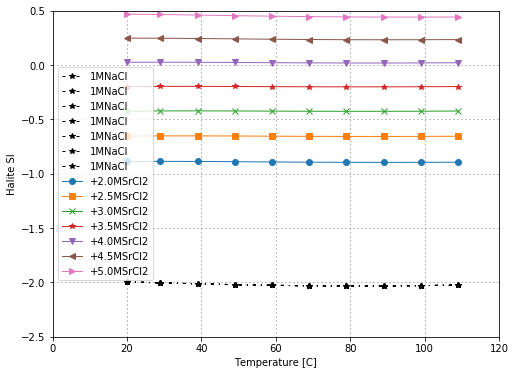

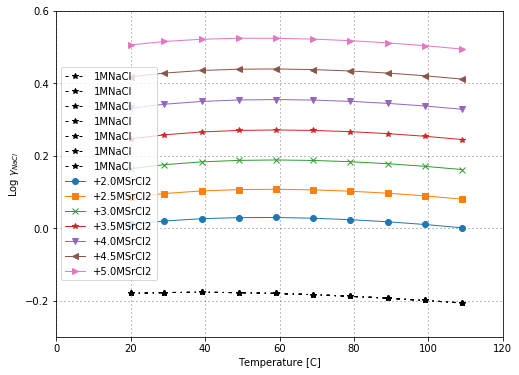

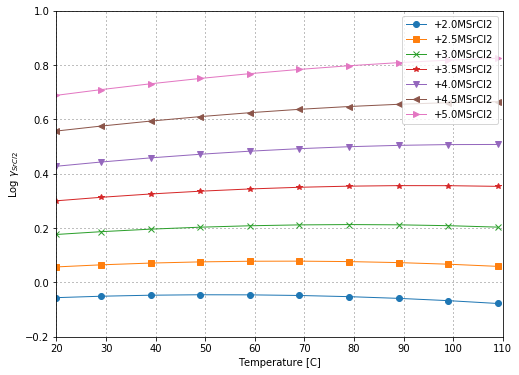

In [17]:
plt.figure(1, figsize=[8, 6])
plt.plot(temp[0::10], si_halite_bc[0::10], marker='*', linestyle='-.', color ='k', label=("%sM%s" % (NaCl, 'NaCl')))

plt.figure(2, figsize=[8, 6])
plt.plot(temp[0::10], log_mean_gam_nacl_bc[0::10], marker='*', linestyle='-.', color ='k', label=("%sM%s" % (NaCl, 'NaCl')))
    
for i in range(0, np.size(log_mean_gam_salt, 1)):
    plt.figure(1, figsize=[8, 6])
#     plt.plot(temp[0::10], si_halite_bc[0::10], marker='*', linestyle='-.', color ='k', label=("%sM%s" % (NaCl, 'NaCl')))
    plt.plot(temp[0::10, i], si_h[0::10, i], marker=mm[i], label= ("+%sM%s" % (X[i], added_salt)))

    plt.figure(2, figsize=[8, 6])
#     plt.plot(temp[0::10], log_mean_gam_nacl_bc[0::10], marker='*', linestyle='-.', color ='k', label=("%sM%s" % (NaCl, 'NaCl')))
    plt.plot(temp[0::10, i], log_mean_gam_nacl[0::10, i], marker=mm[i], label=("+%sM%s" % (X[i], added_salt)))

    plt.figure(3, figsize=[8, 6])
    plt.plot(temp[0::10, i], log_mean_gam_salt[0::10, i], marker=mm[i], label=("+%sM%s" % (X[i], added_salt)))

plt.figure(1)
plt.xlabel('Temperature [C]')
plt.ylabel('Halite SI')
plt.xlim([0, 120])
plt.legend()
# plt.ylim([-0.06, 0.10])
plt.grid()
plt.figure(2)
plt.xlabel('Temperature [C]')
plt.ylabel(r'Log $\gamma_{NaCl}$')
plt.xlim([0, 120])
plt.legend()
# plt.ylim([-0.08, 0.04])
plt.grid()
plt.figure(3)
plt.xlabel('Temperature [C]')
plt.ylabel(r'Log $\gamma_{%s}$' % added_salt)
plt.grid()
plt.legend()

plt.show()